# Import Libraries

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pandas_profiling as pp
%matplotlib inline
from pandas.tseries.offsets import MonthEnd
from matplotlib.pylab import rcParams
pd.plotting.register_matplotlib_converters()
rcParams['figure.figsize'] = (15, 6)
import pmdarima as pm
print('done')

done


# Variables to Set

In [4]:
data = 'forecasting_dataset.csv'
target_column = 'GDP ($ Billions)'
pred_date = '2021-04-13'

# Load/Transform Data

In [5]:
df = pd.read_csv(data)
df.columns = df.columns.str.replace('DATEVALUE', 'Date')
df['Date'] = pd.to_datetime(df['Date'])
df.index = df['Date']
df = df.drop('Date',axis=1)
df

,GDP ($ Billions),Federal Interest rate,Unemployment Rate,Temperature (US Average),Consumer Price Index,S&P House price index
Date,,,,,,
2010-01-01,14611.110,0.11,9.8,30.67,216.687,145.00
2010-02-01,14653.075,0.13,9.8,31.80,216.741,143.06
2010-03-01,14779.004,0.16,9.9,43.57,217.631,143.60
2010-04-01,14842.404,0.20,9.9,53.24,218.009,145.39
2010-05-01,14875.794,0.20,9.6,59.88,218.178,147.02
...,...,...,...,...,...,...
2015-08-01,18111.953,0.14,5.1,72.95,238.316,175.12
2015-09-01,18264.133,0.14,5.1,68.54,237.945,175.24
2015-10-01,18182.577,0.12,5.0,57.25,237.838,175.26


# Profile Data

In [6]:
pp.ProfileReport(df)

# Split into Training and Validation Data

<AxesSubplot:xlabel='Date'>

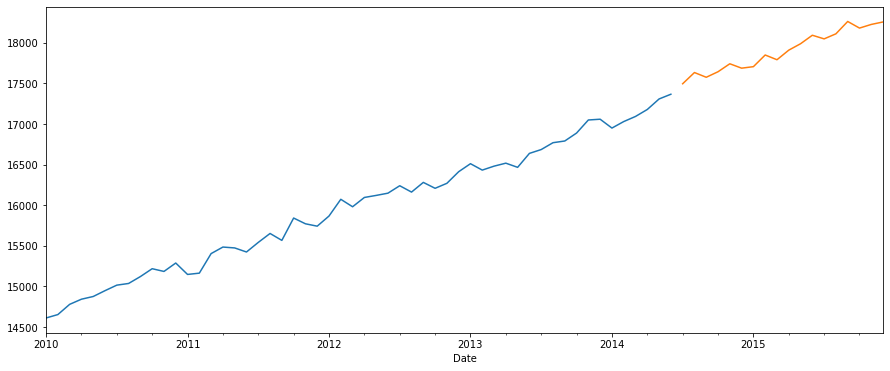

In [7]:
train = df[:int(0.75*(len(df)))]
valid = df[int(0.75*(len(df))):]

#plotting the data
ax = train[target_column].plot()
valid[target_column].plot(ax=ax)

# Stationarity
- Stationarity means that the statistical properties of the process do not change over time
- Random variables of the stochastic process remains the same as we shift it along the time index axis. (Mean and Variance)
- Stationary processes are easier to analyze

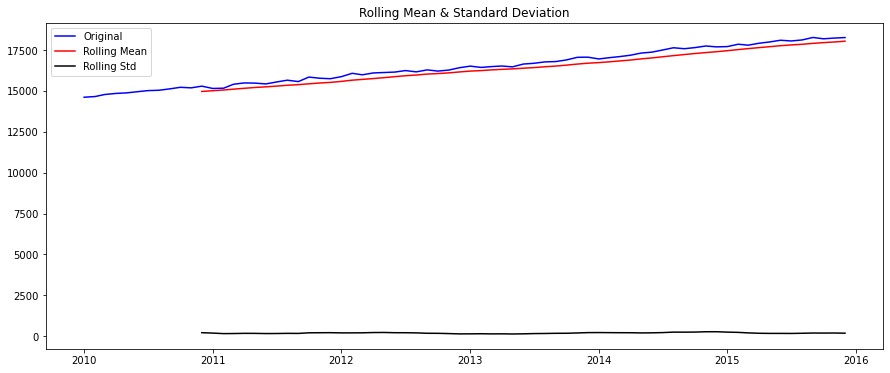

In [8]:
from statsmodels.tsa.stattools import adfuller as adf
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
test_stationarity(df[target_column])

#### Analysis of Stationarity
- Even though there is an increasing trend for GDP, the rolling mean and standard deviations do not have large variances from year to year.

# Trends and Seasonality
 - Plot of Original Data
 - Plot of Smoothed Moving Average of Original Data
 - Plot of Seasonality
     - Seasonality is the presence of variations that occur at specific regular intervals less than a year, such as weekly, monthly, or quarterly
 - Plot of Residuals on a Simple Regression Fit
     - What is left over after fitting a model.

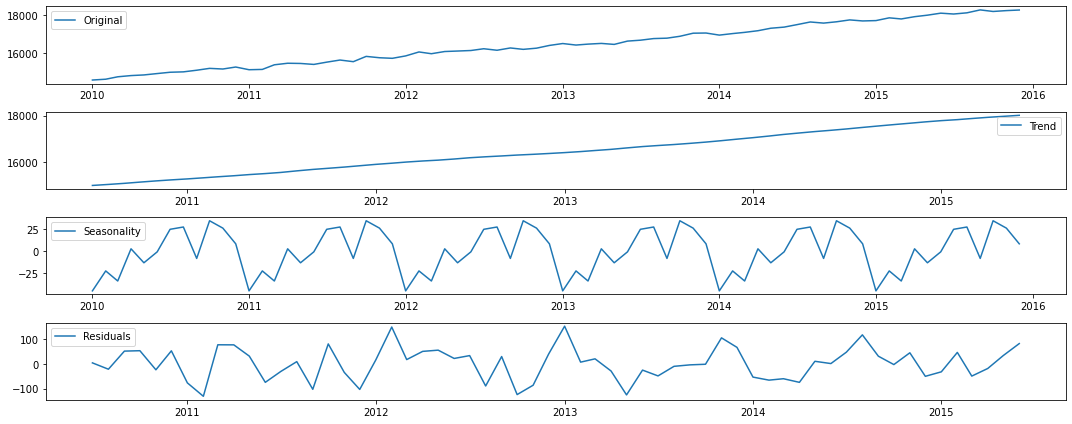

In [9]:
#estimating trend and seasonlity
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df[target_column])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df[target_column], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# ARIMA Modeling without Regressors (Only the Target)
- Autoregressive (AR) integrated (I) moving average (MA) models
- We are not going to go into a lot of detail on the parts of ARIMA, Differencing and Lags (This could be multiple college semester courses)
- Instead, what we will do is use Auto-Arima package to find the best model.

In [10]:
best_noregressors = pm.auto_arima(train.iloc[:,0], 
                   trace=True, error_action='ignore', suppress_warnings=True,
                   seasonal=True,
                   m=12, #12 Months
                   stepwise=False,
                   D=None, 
                   max_D=10,
                   start_p=0, start_q=0, 
                   start_P=0, start_Q=0,
                   max_p=5, max_q=5, max_P=5, max_Q=5,
                   information_criterion='aic', #‘aic’, ‘bic’, ‘hqic’, ‘oob’
                   n_jobs = -1,
                  )

print(best_noregressors)
print('Order :',best_noregressors.order)
print('Seasonal Order :',best_noregressors.seasonal_order)
print('Intercept :',best_noregressors.with_intercept)
print(best_noregressors.summary())


Best model:  ARIMA(2,1,1)(1,0,0)[12] intercept
Total fit time: 70.442 seconds
 ARIMA(2,1,1)(1,0,0)[12] intercept
Order : (2, 1, 1)
Seasonal Order : (1, 0, 0, 12)
Intercept : True
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   54
Model:             SARIMAX(2, 1, 1)x(1, 0, [], 12)   Log Likelihood                -300.635
Date:                             Tue, 13 Apr 2021   AIC                            613.271
Time:                                     14:08:07   BIC                            625.092
Sample:                                          0   HQIC                           617.817
                                              - 54                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----

# Fit Model and Make Predictions on Validation

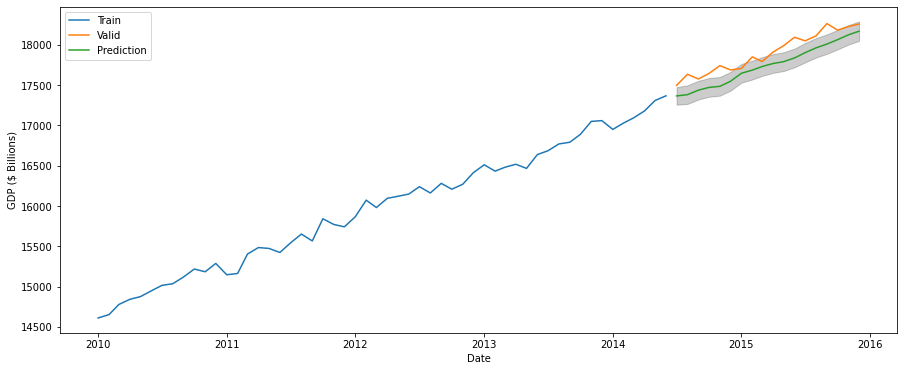

In [11]:
best_noregressors.fit(train.iloc[:,0])
best_noregressors_forecast = best_noregressors.predict(n_periods=len(valid), exogenous=True, return_conf_int=True,  alpha=0.1)

preds_best_noregressors = pd.merge(pd.DataFrame(best_noregressors_forecast[0],
                 index = pd.to_datetime(valid.index),
                 columns=['Prediction']),pd.DataFrame(best_noregressors_forecast[1][:,0],
                        index = pd.to_datetime(valid.index),
                        columns=['Lower']),how='left', left_index=True,right_index=True)

preds_best_noregressors = pd.merge(preds_best_noregressors,pd.DataFrame(best_noregressors_forecast[1][:,1],
                        index = pd.to_datetime(valid.index),
                        columns=['Upper']),how='left',left_index=True,right_index=True)

#plot the predictions for validation set
plt.plot(train.iloc[:,0], label='Train')
plt.plot(valid.iloc[:,0], label='Valid')
plt.plot(preds_best_noregressors.Prediction, label='Prediction')

plt.fill_between(preds_best_noregressors.index,preds_best_noregressors.Lower,preds_best_noregressors.Upper,color='k', alpha=.2)
plt.xlabel('Date')
plt.ylabel(target_column)
plt.legend(loc='best')
plt.show()

# ARIMA Modeling with Regressors (Target and Additional Features)
- exogenous parameter is the ony change

In [12]:
best_regressors = pm.auto_arima(train.iloc[:,0], 
                   trace=True, error_action='ignore', suppress_warnings=True,
                   seasonal=True,
                   m=12, #12 Months
                   stepwise=False,
                   D=None, 
                   max_D=10,
                   start_p=0, start_q=0, 
                   start_P=0, start_Q=0,
                   max_p=5, max_q=5, max_P=5, max_Q=5,
                   information_criterion='aic', #‘aic’, ‘bic’, ‘hqic’, ‘oob’
                   n_jobs = -1,
                   exogenous=train.iloc[:,1:]
                  )

print(best_regressors)
print('Order :',best_regressors.order)
print('Seasonal Order :',best_regressors.seasonal_order)
print('Intercept :',best_regressors.with_intercept)
print(best_regressors.summary())


Best model:  ARIMA(2,0,2)(0,0,1)[12] intercept
Total fit time: 114.584 seconds
 ARIMA(2,0,2)(0,0,1)[12] intercept
Order : (2, 0, 2)
Seasonal Order : (0, 0, 1, 12)
Intercept : True
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                   54
Model:             SARIMAX(2, 0, 2)x(0, 0, [1], 12)   Log Likelihood                -317.615
Date:                              Tue, 13 Apr 2021   AIC                            659.230
Time:                                      14:16:55   BIC                            683.098
Sample:                                  01-01-2010   HQIC                           668.435
                                       - 06-01-2014                                         
Covariance Type:                                opg                                         
                               coef    std err          z      P>|z|      [

# Fit Model and Make Predictions on Validation

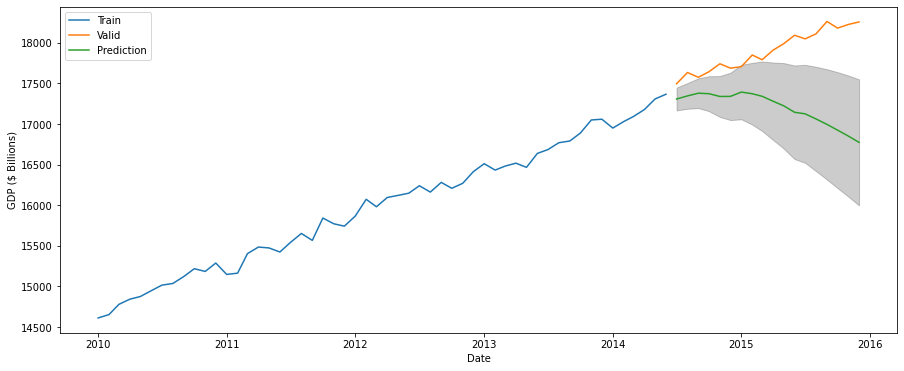

In [13]:
best_regressors.fit(train.iloc[:,0])
best_regressors_forecast = best_regressors.predict(n_periods=len(valid), exogenous=True, return_conf_int=True,  alpha=0.1)

preds_best_regressors = pd.merge(pd.DataFrame(best_regressors_forecast[0],
                 index = pd.to_datetime(valid.index),
                 columns=['Prediction']),pd.DataFrame(best_regressors_forecast[1][:,0],
                        index = pd.to_datetime(valid.index),
                        columns=['Lower']),how='left', left_index=True,right_index=True)

preds_best_regressors = pd.merge(preds_best_regressors,pd.DataFrame(best_regressors_forecast[1][:,1],
                        index = pd.to_datetime(valid.index),
                        columns=['Upper']),how='left',left_index=True,right_index=True)

#plot the predictions for validation set
plt.plot(train.iloc[:,0], label='Train')
plt.plot(valid.iloc[:,0], label='Valid')
plt.plot(preds_best_regressors.Prediction, label='Prediction')

plt.fill_between(preds_best_regressors.index,preds_best_regressors.Lower,preds_best_regressors.Upper,color='k', alpha=.2)
plt.xlabel('Date')
plt.ylabel(target_column)
plt.legend(loc='best')
plt.show()

# Choose a ARIMA model and predict future

In [17]:
pred_months = 12
model = best_regressors.fit(df.iloc[:,0])



forecast = model.predict(n_periods=pred_months, exogenous=True, return_conf_int=True,  alpha=0.25)

preds = pd.merge(pd.DataFrame(forecast[0],
                 index = pd.Index(pd.date_range(df.index.max(), periods=pred_months+1, freq='M').tolist()[1:]),
                 columns=['Prediction']),pd.DataFrame(forecast[1][:,0],
                        index = pd.Index(pd.date_range(df.index.max(), periods=pred_months+1, freq='M').tolist()[1:]),
                        columns=['Lower']),how='left', left_index=True,right_index=True)

preds = pd.merge(preds,pd.DataFrame(forecast[1][:,1],
                        index = pd.Index(pd.date_range(df.index.max(), periods=pred_months+1, freq='M').tolist()[1:]),
                        columns=['Upper']),how='left',left_index=True,right_index=True)

preds['Pred_Date'] = pred_date

display(preds)

,Prediction,Lower,Upper,Pred_Date
2016-01-31,18247.757954,18146.154893,18349.361015,2021-04-13
2016-02-29,18227.439296,18100.972988,18353.905603,2021-04-13
2016-03-31,18212.284580,18056.574107,18367.995052,2021-04-13
2016-04-30,18173.832895,17985.650619,18362.015170,2021-04-13
2016-05-31,18128.594049,17905.542119,18351.645980,2021-04-13
2016-06-30,18072.554643,17812.851474,18332.257812,2021-04-13
2016-07-31,18018.636962,17720.983379,18316.290545,2021-04-13
2016-08-31,17948.228659,17611.721950,18284.735369,2021-04-13
2016-09-30,17864.264854,17488.340699,18240.189009,2021-04-13
2016-10-31,17789.748426,17374.139237,18205.357615,2021-04-13


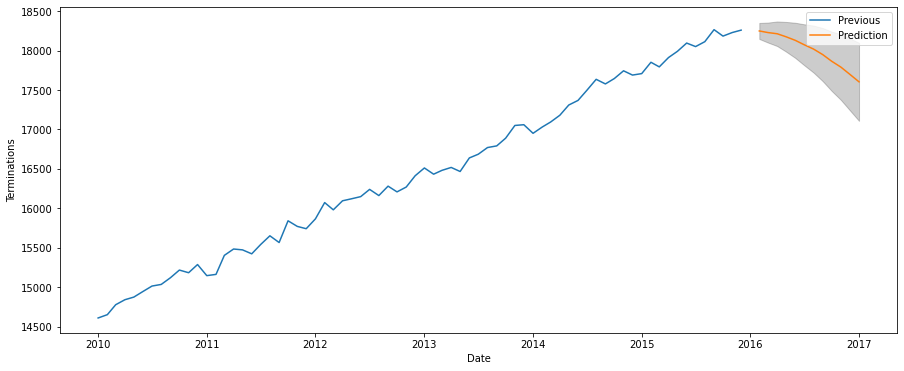

In [18]:
#plot the predictions for validation set
plt.plot(df.iloc[:,0], label='Previous')
plt.plot(preds.Prediction, label='Prediction')

plt.fill_between(preds.index,preds.Lower,preds.Upper,color='k', alpha=.2)
plt.xlabel('Date')
plt.ylabel('Terminations')
plt.legend(loc='best')
plt.show()